# LiDAR Uncertainty at SOAP and NEON sites

## The SOAP site
![Soaproot Panorama](img/Soaproot_pano.jpeg)
Image credit: National Ecological Observtory Network, available at: https://www.neonscience.org/field-sites/soap

In [1]:
import os
import pathlib

import earthpy as et
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns
import clean

et.data.get_data('spatial-vector-lidar')

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)
os.chdir(home_dir)

In [2]:
# add to clean.py
# can import individual functions from library
# from clean import norm_diff, MY_VARIABLE
def norm_diff(band_1, band_2):
    (band_2 - band_1)/(band_2 + band_1)

In [3]:
print(clean.MY_VARIABLE)

None


In [2]:
# Paths to SJER data
sjer_base_dir = os.path.join(
    'california',
    'neon-sjer-site')

sjer_insitu_path = os.path.join(
    sjer_base_dir,
    '2013',
    'insitu',
    'veg_structure',
    'D17_2013_SJER_vegStr.csv')

sjer_chm_path = os.path.join(
    sjer_base_dir,
    '2013',
    'lidar',
    'SJER_lidarCHM.tif')

sjer_plots_path = os.path.join(
    sjer_base_dir,
    'vector_data',    
    'SJER_plot_centroids.shp')

# Paths to SOAP data
soap_base_dir = os.path.join(
    'california',
    'neon-soap-site')

soap_insitu_path = os.path.join(
    soap_base_dir,
    '2013',
    'insitu',
    'veg-structure',
    'D17_2013_SOAP_vegStr.csv')

soap_chm_path = os.path.join(
    soap_base_dir,
    '2013',
    'lidar',
    'SOAP_lidarCHM.tif')

soap_plots_path = os.path.join(
    soap_base_dir,
    'vector_data',    
    'SOAP_centroids.shp')

In [42]:
# Enter parameters for variables that exist outside function (eg, paths)
# Get rid of specifics(e.g., sjer_)
def calc_lidar_chm_stats(plots_path, chm_path):
    """
    Calculates max and mean tree height from LiDAR
    
    Parameters
    ----------
    plots_path: path
        path to the plot shapefile
        
    chm_paths: path
        path to the lidar CHM data (tif file)
        
    Returns
    ---------
    chm_stats_gdf: gdf
        geodataframe containing max and mean canopy height
    """
    
    # Calculate the plot perimeters
    plots_gdf = gpd.read_file(plots_path)
    plots_gdf.geometry = plots_gdf.geometry.buffer(20)
    
    # Calculate zonal statistics - creates Dictionary
    chm_stats = rs.zonal_stats(
            plots_gdf, chm_path,
            stats =['mean', 'max'], nodata=0, 
            geojson_out=True, copy_properties=True)

    # Create GDF with max and mean
    chm_stats_gdf = gpd.GeoDataFrame.from_features(chm_stats)
    chm_stats_gdf.rename(
        columns={'max': 'lidar_max', 'mean': 'lidar_mean'},
        inplace=True)
    
    return chm_stats_gdf

In [43]:
# Call function to build gdf for sjer and soap sites
sjer_lidar_df = calc_lidar_chm_stats(
    plots_path=sjer_plots_path, 
    chm_path=sjer_chm_path)

soap_lidar_df = calc_lidar_chm_stats(
    plots_path=soap_plots_path, 
    chm_path=soap_chm_path)

In [44]:
def calc_insitu_height_stats(insitu_path):
    """
    Calculate max and mean tree height from insitu data
    
    Parameters
    ----------
    insitu_path: path
        path to insitu data (csv file)
        
    Returns
    ---------
    insitu_stats_gdf: gdf
        geodataframe containing max and mean canopy height
    """
    insitu_stats_df = (
        pd.read_csv(insitu_path)
        .groupby('plotid')
        .stemheight
        .agg(['max', 'mean'])
        .rename(columns={'max': 'insitu_max', 'mean': 'insitu_mean'}))

    return insitu_stats_df

In [45]:
# Combine functions to create merged df with lidar and insitu data
def calc_height_stats(
    plots_path, chm_path, insitu_path, id_col='Plot_ID'):
    """
    Calculate max and mean tree height from lidar and insitu data
    
    Parameters
    ----------
    plots_path: path
        path to the plot shapefile
        
    chm_paths: path
        path to the lidar CHM data (tif file)
        
    insitu_path: path
        path to insitu data (csv file)
        
    id_col: str
        name of the plot ID column
        
    Returns
    ---------
    stat_gdf: gdf
        geodataframe containing plot IDs and lidar and insitu
        max and mean canopy height
    """
    
    chm_stats_gdf = calc_lidar_chm_stats(
        plots_path=plots_path,
        chm_path=chm_path)
    
    #if (chm_stats_gdf.id_col[0]).isnumeric():
     #   chm_stats_gdf.id_col = 'SOAP' + chm_stats_gdf['id_col']
    
    insitu_height_df = calc_insitu_height_stats(
        insitu_path=insitu_path)
    
    stat_df = (
        chm_stats_gdf
        .merge(insitu_height_df, right_index=True, left_on=id_col))

    return stat_df

In [46]:
sjer_stat_gdf = calc_height_stats(
    plots_path=sjer_plots_path,
    chm_path=sjer_chm_path,
    insitu_path=sjer_insitu_path,
    id_col='Plot_ID')

sjer_stat_gdf

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,insitu_max,insitu_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544347,19.3,3.866667
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,23.9,8.221429
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,16.0,8.218750
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675346,11.0,6.512500
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591177,8.8,7.600000
5,"POLYGON ((257098.867 4111388.570, 257098.771 4...",SJER128,center,4111388.570,257078.867,trees,19.139999,8.987087,18.2,5.211765
6,"POLYGON ((256703.434 4111071.087, 256703.338 4...",SJER192,center,4111071.087,256683.434,grass,16.549999,7.229096,13.7,6.769565
7,"POLYGON ((256737.467 4112167.778, 256737.371 4...",SJER272,center,4112167.778,256717.467,trees,11.840000,7.107061,12.4,6.819048
8,"POLYGON ((256054.390 4111533.879, 256054.294 4...",SJER2796,center,4111533.879,256034.390,soil,20.279999,6.409630,9.4,5.085714
9,"POLYGON ((258517.102 4109856.983, 258517.006 4...",SJER3239,center,4109856.983,258497.102,soil,12.910000,6.009128,17.9,3.920833


In [15]:
# need to fix the merge for SOAP
#plotid SOAP1343
#calc_height_stats(
 #   plots_path=soap_plots_path,
  #  chm_path=soap_chm_path,
   # insitu_path=soap_insitu_path)
calc_insitu_height_stats(
        insitu_path=soap_insitu_path)

calc_lidar_chm_stats(
        plots_path=soap_plots_path,
        chm_path=soap_chm_path)

,geometry,OBJECTID,ID,plotType,subtype,plotDimens,Protocols,lidar_max,lidar_mean
0,"POLYGON ((297815.197 4101493.028, 297815.101 4...",1,27,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.250000,20.455827
1,"POLYGON ((297065.197 4100713.028, 297065.101 4...",2,43,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",54.099998,19.804080
2,"POLYGON ((299825.197 4101013.028, 299825.101 4...",3,63,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",32.480000,16.989834
3,"POLYGON ((298175.197 4101433.028, 298175.101 4...",4,91,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",50.309998,21.980976
4,"POLYGON ((298715.197 4100833.028, 298715.101 4...",5,95,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",33.869999,17.412048
5,"POLYGON ((297065.197 4100083.028, 297065.101 4...",6,139,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",49.919998,19.417840
6,"POLYGON ((299885.197 4100413.028, 299885.101 4...",7,143,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",27.340000,10.454653
7,"POLYGON ((297545.197 4100533.028, 297545.101 4...",8,187,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",47.959999,13.221389
8,"POLYGON ((298775.197 4101403.028, 298775.101 4...",9,287,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",53.969997,17.602865
9,"POLYGON ((297515.197 4100683.028, 297515.101 4...",10,299,distributed,base,40.0,"beetles, soils, coarse-downed wood, leaf area ...",34.189999,18.852112


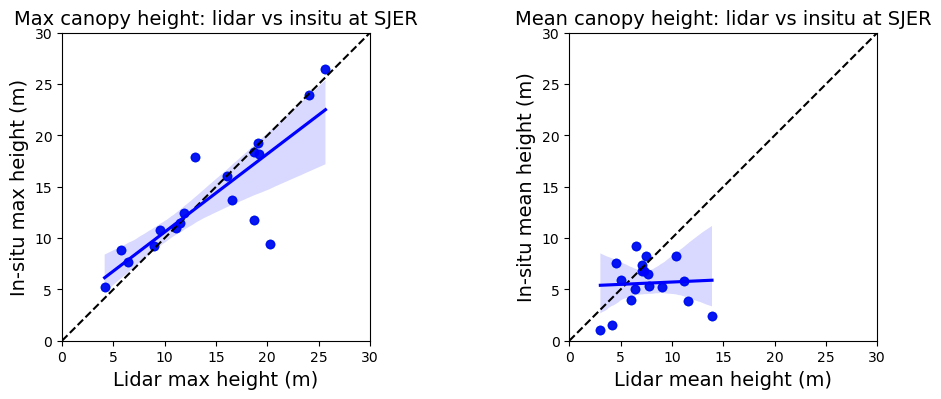

In [47]:
def plot_height(plots_path, chm_path, insitu_path, site_name):
    
    plot_gdf = calc_height_stats(
        plots_path=plots_path,
        chm_path=chm_path,
        insitu_path=insitu_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    ax1.scatter(plot_gdf.lidar_max, plot_gdf.insitu_max)
    ax1.plot((0,1), (0,1), transform=ax1.transAxes, ls='--', c='k')
    sns.regplot(x='lidar_max', y='insitu_max',
                data=plot_gdf,
                color='blue',
                ax=ax1)
    ax1.set(xlim=(0,30), ylim=(0,30), aspect='equal',
           title=('Max canopy height: lidar vs insitu at {}'
                  .format(site_name)),
           xlabel='Lidar max height (m)',
           ylabel='In-situ max height (m)')
    ax1.xaxis.label.set_fontsize(14)
    ax1.yaxis.label.set_fontsize(14)
    ax1.title.set_fontsize(14)

    ax2.scatter(plot_gdf.lidar_mean, plot_gdf.insitu_mean)
    ax2.plot((0,1), (0,1), transform=ax2.transAxes, ls='--', c='k')
    sns.regplot(x='lidar_mean', y='insitu_mean',
                data=plot_gdf,
                color='blue',
                ax=ax2)
    ax2.set(xlim=(0,30), ylim=(0,30), aspect='equal',
           title=('Mean canopy height: lidar vs insitu at {}'
                  .format(site_name)),
           xlabel='Lidar mean height (m)',
           ylabel='In-situ mean height (m)')
    ax2.xaxis.label.set_fontsize(14)
    ax2.yaxis.label.set_fontsize(14)
    ax2.title.set_fontsize(14)

    plt.show()

plot_height(
    plots_path=sjer_plots_path,
    chm_path=sjer_chm_path,
    insitu_path=sjer_insitu_path,
    site_name='SJER')